Notebook to implement mask augmentation based on low frequencies




In [1]:
#ico class
import os
import numpy as np
import nibabel as nb
import copy
from scipy import sparse 
import meld_classifier.mesh_tools as mt
import torch
from math import pi 
import logging
from meld_graph.icospheres import IcoSpheres
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
import matplotlib_surface_plotting as msp
from scipy.stats import special_ortho_group
from scipy.spatial import cKDTree
# import logging
# logging.basicConfig(level=logging.DEBUG)

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 


In [2]:
#initialise cohort
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')

# initialise icospheres
icos=IcoSpheres(conv_type='SpiralConv')
# Select icosphere
ico_index=7
ico_ini = icos.icospheres[ico_index]

# initialise inflated brain
coords = cohort.surf["coords"]
faces = cohort.surf["faces"]

In [50]:
# load lesion for a patient

subject = 'MELD_H9_3T_FCD_0007'
s = MeldSubject(subject,cohort=cohort)

hemi = s.get_lesion_hemisphere()

dists, labels = s.load_feature_lesion_data(
            features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
        )

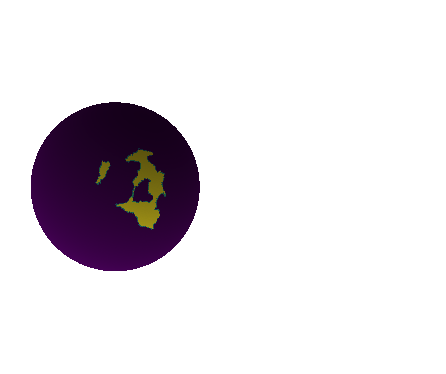

In [40]:
# plot lesion before augmentation

overlay=labels
# msp.plot_surf(coords,faces, 
#                 overlay,
#                 flat_map=False,
#                 rotate=[90, 270],
#              )


msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              overlay,
              colorbar=False,
              rotate=[120],z_rotate=-70,
                 )

In [51]:
# function to augment mask 

import potpourri3d as pp3d
from meld_graph.models import HexUnpool, HexPool
def unpool(level=7):
    num = len(icos.get_neighbours(level=level))
    upsample = icos.get_upsample(target_level=level)
    unpooling = HexUnpool(upsample_indices=upsample, target_size=num)
    return unpooling

def augment_mask(mask, noise_std=0.5):

    # get geodesic distance (negative inside lesion, positive outside)
    solver = pp3d.MeshHeatMethodDistanceSolver(coords,faces)
    n_vert = len(coords)
    indices = np.arange(n_vert,dtype=int)
    new_dist = solver.compute_distance_multisource(indices[mask>0])

    # normalise by minimum values
    new_dist_norm = new_dist / np.abs(new_dist.min())

    # create low frequencies noise on low res icosphere
    ico_low_index=2
    ico_low = icos.icospheres[ico_low_index]
    n_vert_low = len(ico_low['coords'])
    noise = np.random.normal(-1*noise_std,noise_std,n_vert_low)

    #upsample noise to high res
    for level in range(ico_low_index, 7):
        unpool_ind = unpool(level=level+1)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        noise_upsampled = unpool_ind(torch.from_numpy(noise.reshape(-1,1)), device = device)
        noise_upsampled = noise_upsampled.detach().cpu().numpy().ravel()
        noise = noise_upsampled.copy()
    
    #add noise to distance normalised
    new_mask = (new_dist_norm + noise_upsampled)<=0

    return new_mask
    

In [52]:
mask_augmented_array=[]
for i in range(0,12):
    mask_augmented_array.append(augment_mask(labels, noise_std=1))

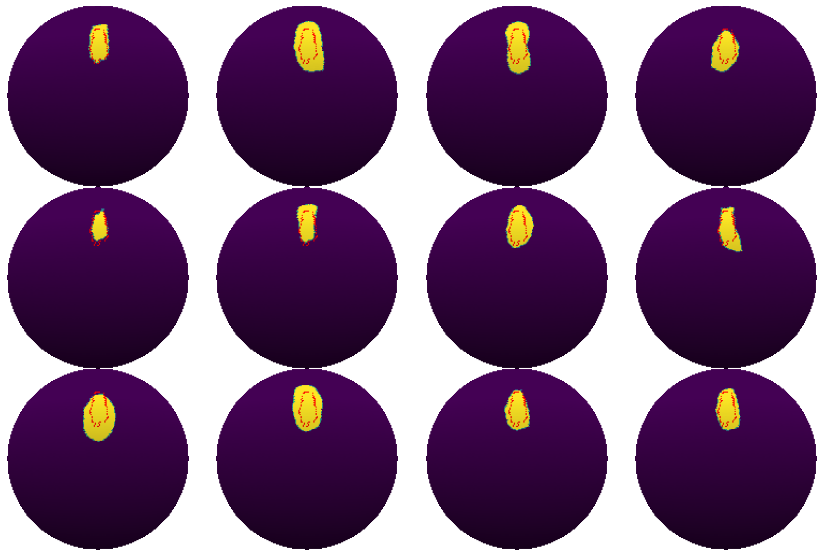

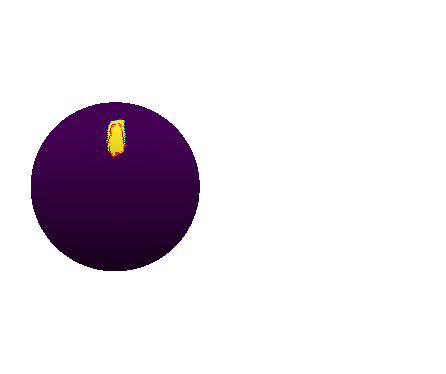

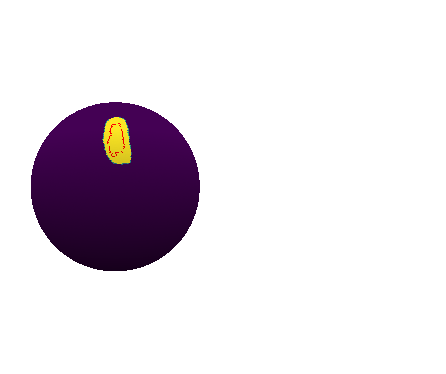

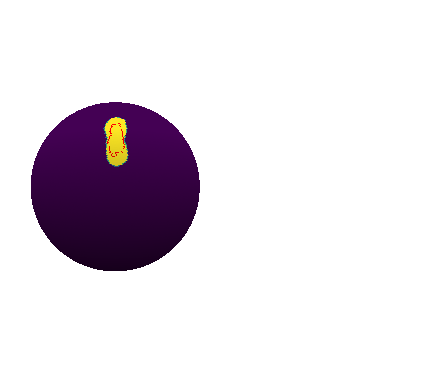

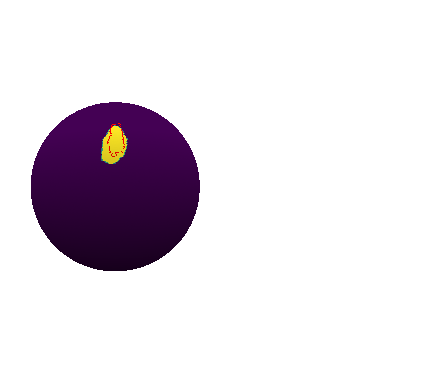

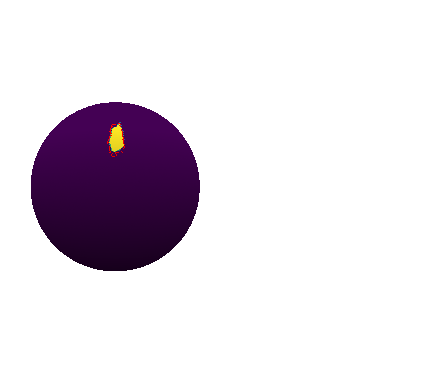

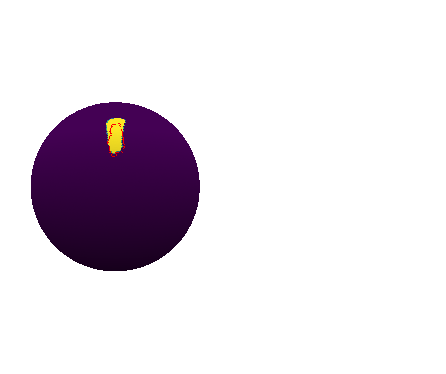

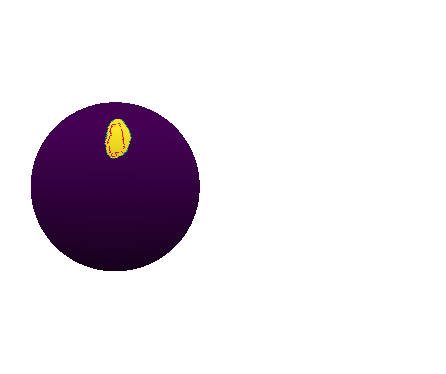

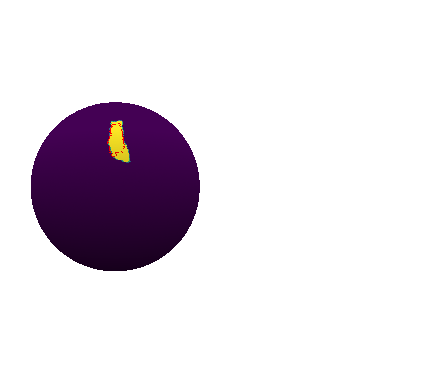

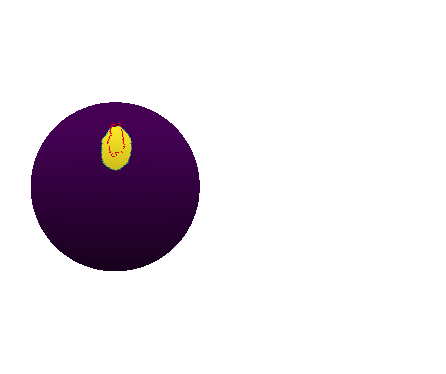

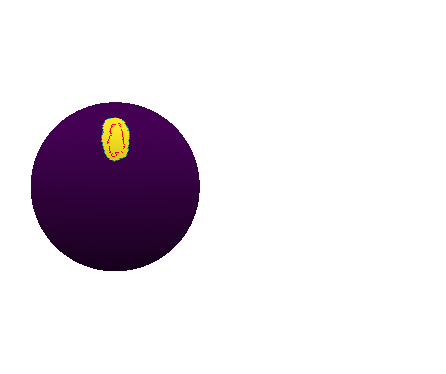

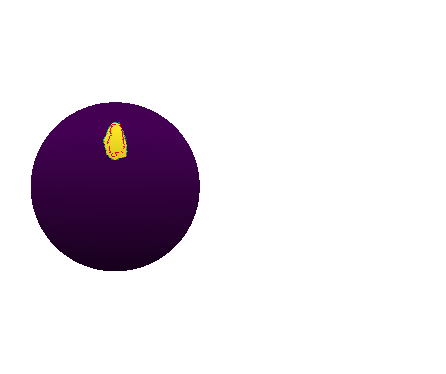

In [53]:
# plot lesion after augmentation
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def create_surface_plots(coords,faces,overlay,flat_map=True, parcel = None):
    """plot and reload surface images"""
    from meld_classifier.meld_plotting import trim
    import matplotlib_surface_plotting.matplotlib_surface_plotting as msp
    from PIL import Image
    import numpy as np
    parcel_cmap = {1:[1,0,0,0]}
    msp.plot_surf(coords,faces, 
                overlay,
                flat_map=flat_map,
                parcel = parcel, 
                parcel_cmap = parcel_cmap,
                rotate=[270],
                # rotate=[100],z_rotate=-70,
                show_back=True,
                filename='tmp.png',
                colorbar=False,
             )
    im = Image.open('tmp.png')
    im = trim(im)
    im = im.convert("RGBA")
    im1 = np.array(im)
    return im1

fig= plt.figure(figsize=(15,10), constrained_layout=True)
gs1 = GridSpec(3, 4,  wspace=0, hspace=0)

for i, overlay in enumerate(mask_augmented_array):
    ax = fig.add_subplot(gs1[i])
    im = create_surface_plots(ico_ini['coords'],ico_ini['faces'],overlay,flat_map=False, parcel=labels)
    ax.imshow(im)
    ax.axis('off')
    
plt.close()

## Implementation

In [22]:
# get geodesic distance (negative inside lesion, positive outside)
import potpourri3d as pp3d
solver = pp3d.MeshHeatMethodDistanceSolver(coords,faces)
n_vert = len(coords)
indices = np.arange(n_vert,dtype=int)

new_dist = solver.compute_distance_multisource(indices[labels>0])


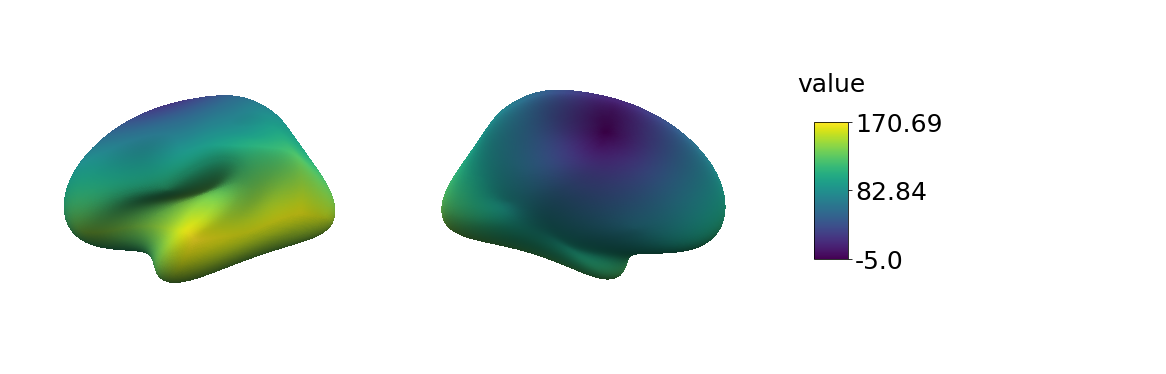

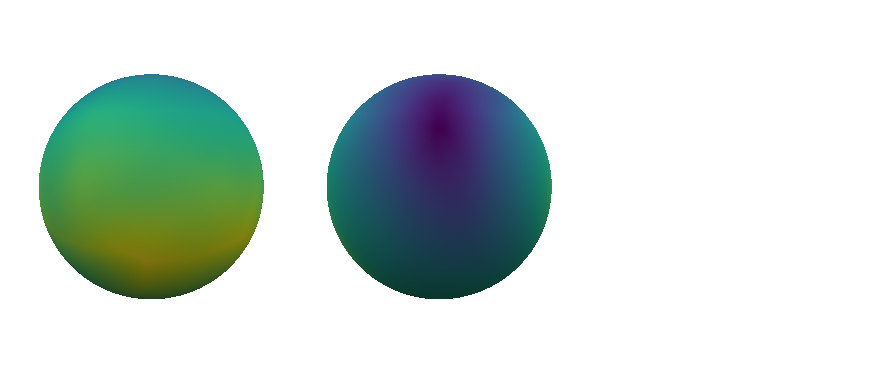

In [23]:
# plot new distance

overlay=(new_dist>=-0.2)&(new_dist<=0.2)
overlay=new_dist
msp.plot_surf(coords,faces, 
                overlay,
                flat_map=False,
                rotate=[90, 270],
             )


msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              overlay,
              colorbar=False
                 )

In [24]:
# normalise by minimum values

new_dist_norm = new_dist / np.abs(new_dist.min())

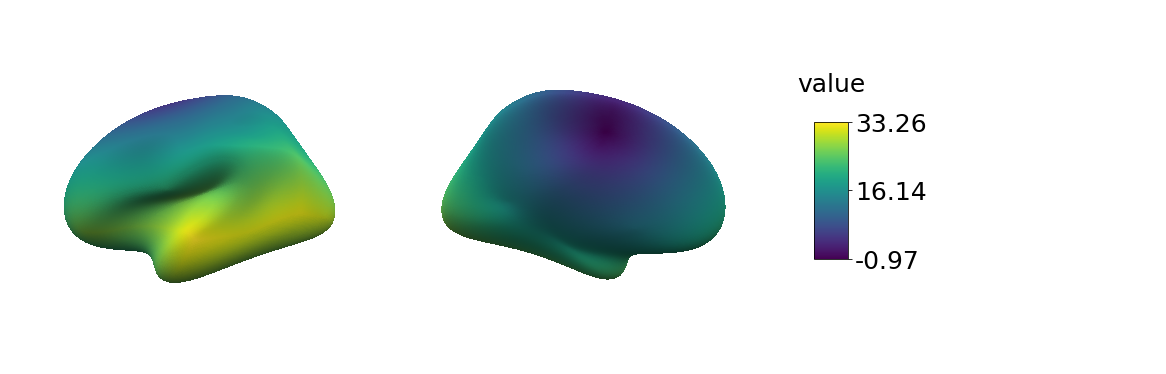

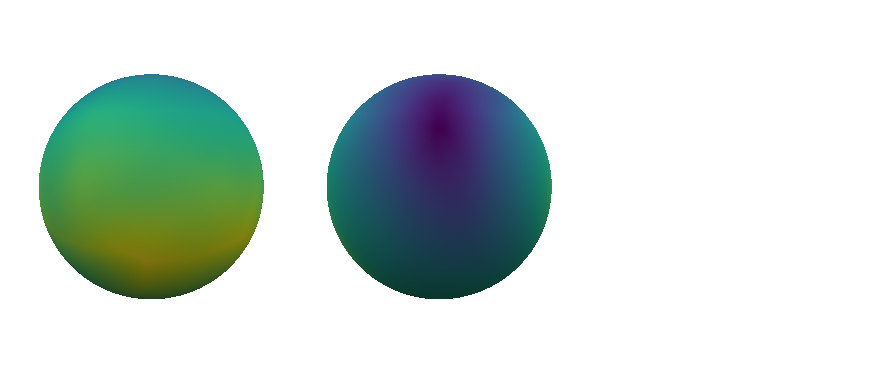

In [25]:
# plot new distance normed

overlay=new_dist_norm
msp.plot_surf(coords,faces, 
                overlay,
                flat_map=False,
                rotate=[90, 270],
             )


msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              overlay,
              colorbar=False
                 )

162


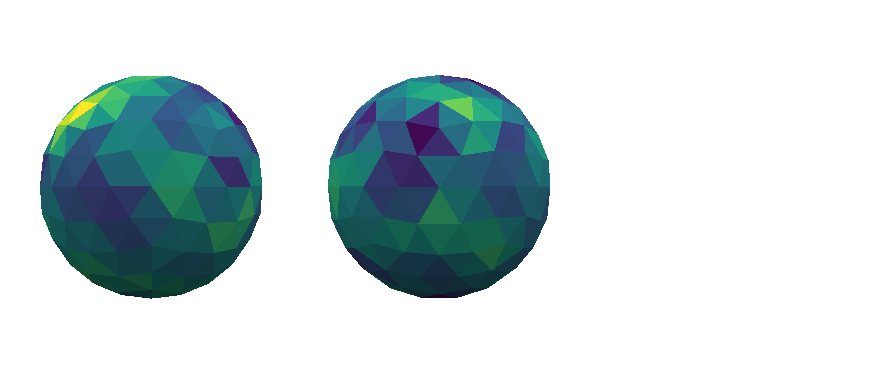

In [35]:
# create low frequencies noise and add to boundaries

# Select low res icosphere
ico_low_index=2
ico_low = icos.icospheres[ico_low_index]
n_vert_low = len(ico_low['coords'])
print(n_vert_low)

noise = np.random.normal(-0.5,0.5,n_vert_low)

#plot noise low res
msp.plot_surf(ico_low['coords'],
              ico_low['faces'],
              noise,
              colorbar=False
                 )


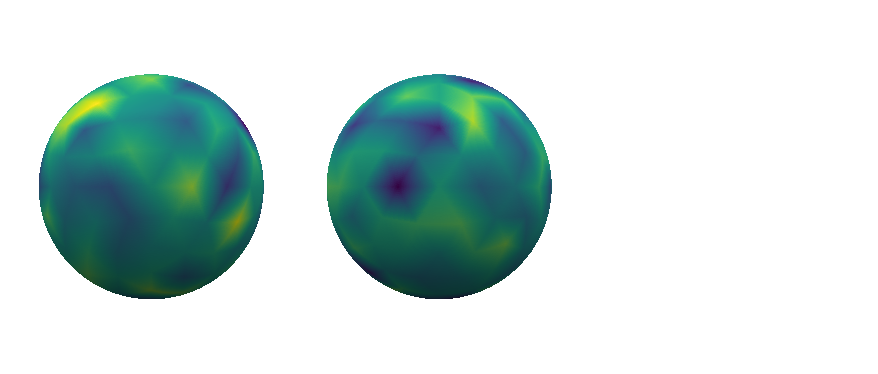

In [36]:
#upsample noise to high res
from meld_graph.models import HexUnpool, HexPool
def unpool(level=7):
    num = len(icos.get_neighbours(level=level))
    upsample = icos.get_upsample(target_level=level)
    unpooling = HexUnpool(upsample_indices=upsample, target_size=num)
    return unpooling

for level in range(ico_low_index, 7):
    unpool_ind = unpool(level=level+1)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    noise_upsampled = unpool_ind(torch.from_numpy(noise.reshape(-1,1)), device = device)
    noise_upsampled = noise_upsampled.detach().cpu().numpy().ravel()
    noise = noise_upsampled.copy()
    
#plot noise low res
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              noise_upsampled,
              colorbar=False
                 )

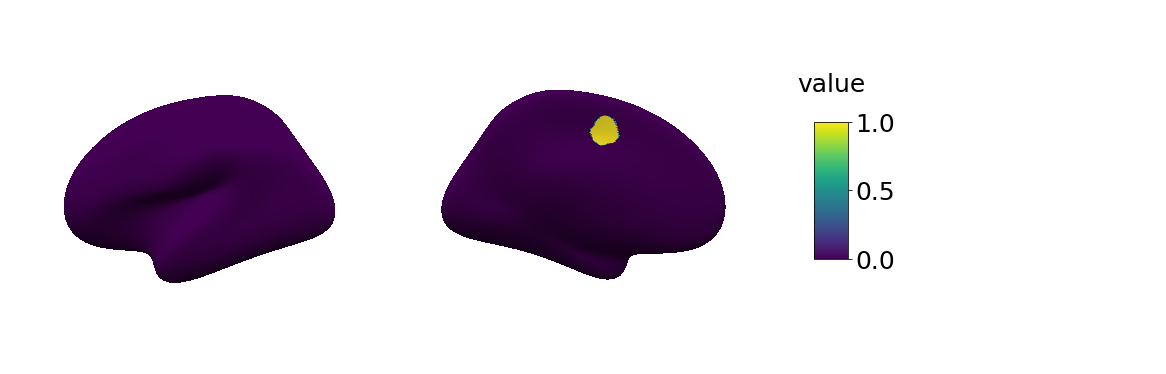

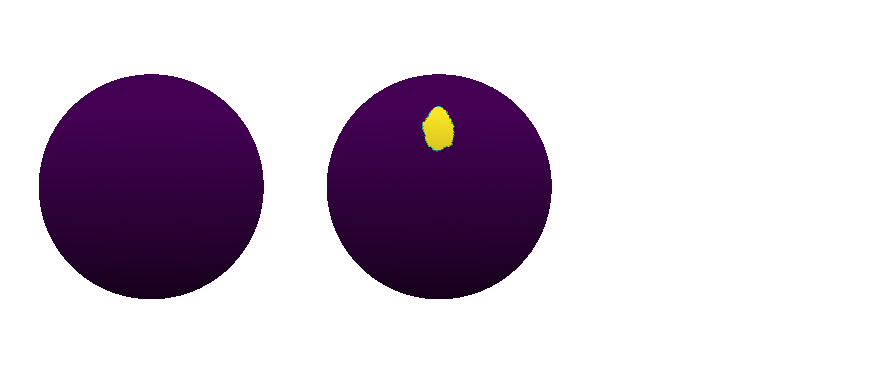

In [37]:
# add upsample noise to distance and threshold

new_labels = (new_dist_norm + noise_upsampled)<=0

overlay=new_labels
msp.plot_surf(coords,faces, 
                overlay,
                flat_map=False,
                rotate=[90, 270],
             )


msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              overlay,
              colorbar=False
                 )